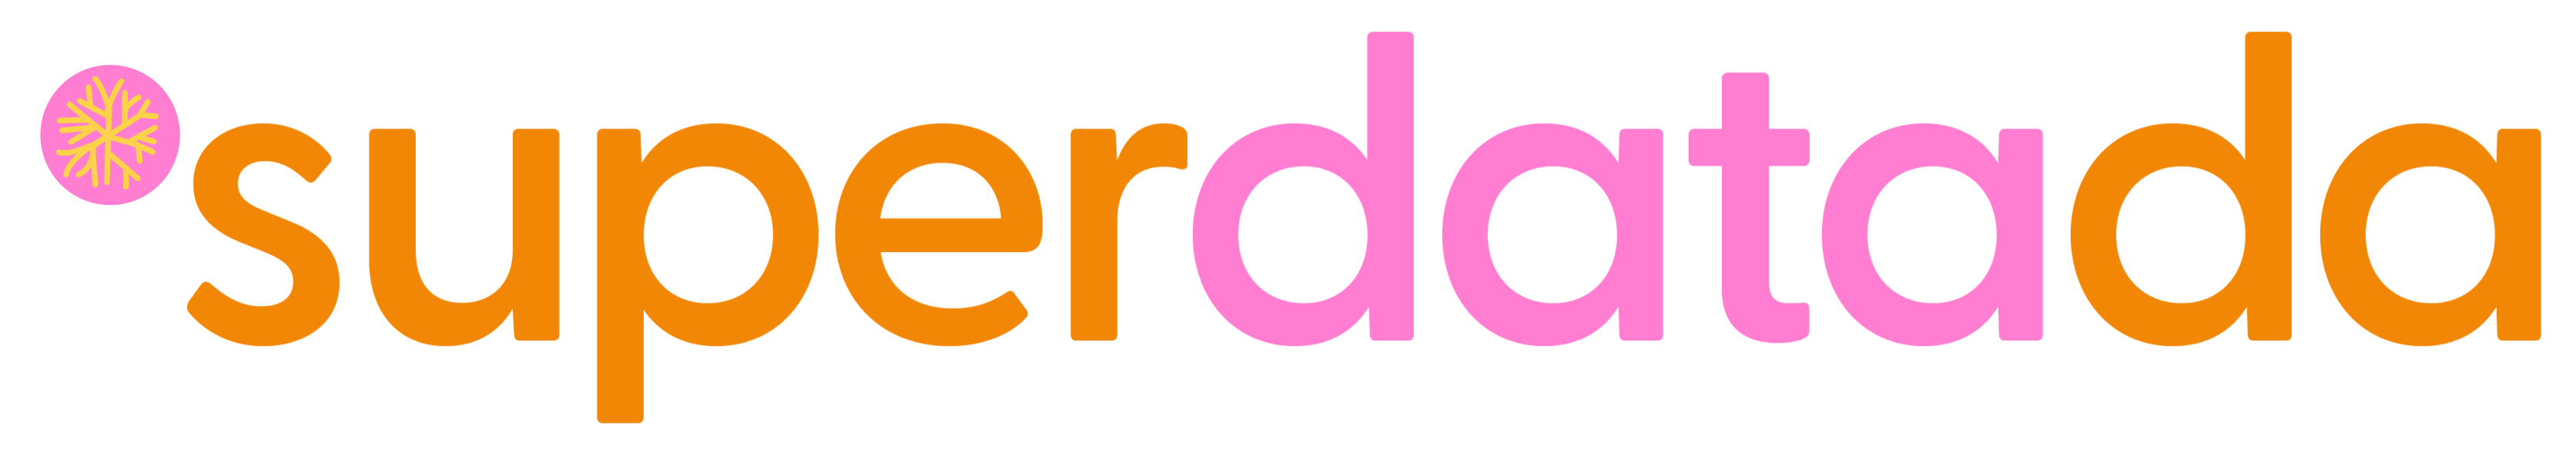

# 📸⏰ ¿A qué hora tienes que citar a tus invitados en México?


¡Hora de poner a prueba la puntualidad! 🕵️‍♂️

En este notebook 🧑‍💻 aprenderás cómo extraer la hora exacta de llegada de tus invitados usando la metadata de sus fotos 📷. ¡Nada como una cámara para atrapar al que llegó tarde! 😅

Luego, con esos datos, haremos un bello y revelador [diagrama de caja y bigotes](https://es.wikipedia.org/wiki/Diagrama_de_caja#:~:text=Un%20diagrama%20de%20caja%20(tambi%C3%A9n,pueden%20representarse%20sus%20valores%20at%C3%ADpicos.) 📊 que te permitirá visualizar quién llegó a tiempo, quién corrió y quién se pasó de relajado 🐢🏃‍♀️🎉

Prepárate para un análisis tan elegante como nuestra fiesta de lanzamiento... ¡pero con pandas y matplotlib! 🐼✨

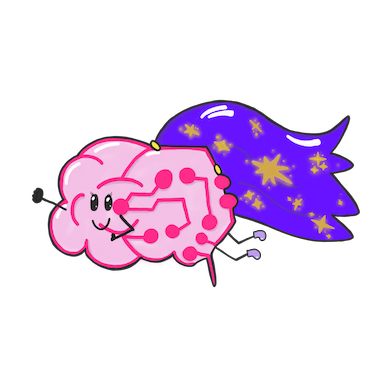

# 1. Prep ⚙️

In [1]:
import os
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from PIL.ExifTags import TAGS
import seaborn as sns

In [2]:
def get_datetime_original(image_path):
    """
    Extrae la fecha y hora original de una imagen usando metadatos EXIF.

    Args:
        image_path (str): Ruta al archivo de imagen.

    Returns:
        str: Valor de 'DateTimeOriginal' en formato EXIF, o None si no se encuentra.
    """
    try:
        with Image.open(image_path) as image:
            exif_data = image._getexif()
            if not exif_data:
                return None
            for tag_id, value in exif_data.items():
                tag = TAGS.get(tag_id, tag_id)
                if tag == 'DateTimeOriginal':
                    return value
    except Exception as e:
        print(f"Error con {image_path}: {e}")
    return None

def extract_photo_metadata(folder_path):
    """
    Extrae metadatos de fecha y hora de todas las imágenes JPG/JPEG en una carpeta.

    Args:
        folder_path (str): Ruta a la carpeta con imágenes.

    Returns:
        pd.DataFrame: DataFrame con columnas 'Filename' y 'DateTimeOriginal'.
    """
    data = []
    if not os.path.isdir(folder_path):
        print(f"Carpeta no encontrada: {folder_path}")
        return pd.DataFrame(columns=['Filename', 'DateTimeOriginal'])
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            full_path = os.path.join(folder_path, filename)
            dt_original = get_datetime_original(full_path)
            data.append({'Filename': filename, 'DateTimeOriginal': dt_original})
    df_result = pd.DataFrame(data)
    if df_result.empty:
        print("No se encontraron imágenes JPG/JPEG en la carpeta.")
    return df_result

# 2. Datos 📊

In [3]:
# 📂 CAMBIA ESTO a la ruta donde subiste tus fotos
folder_path = ''

# Extraer metadatos
df_fotos = extract_photo_metadata(folder_path)
df_fotos.head()

,Filename,DateTimeOriginal
0,IMG_2695.JPG,2025:05:17 19:06:30
1,IMG_2696.JPG,2025:05:17 19:07:07
2,IMG_2697.JPG,2025:05:17 19:09:42
3,IMG_2698.JPG,2025:05:17 19:12:55
4,IMG_2699.JPG,2025:05:17 19:13:49


In [4]:
# Hora y fecha de la cita
# Cambia esto a la fecha y hora de tu cita
# 2025:05:17 19:00:00
fecha_cita = "2025:05:17 19:00:00"
tiempo_base = datetime.strptime(fecha_cita, "%Y:%m:%d %H:%M:%S") 

In [7]:
# Conversión segura a datetime (ignora valores nulos o vacíos)
df_fotos['DateTimeOriginal'] = pd.to_datetime(
    df_fotos['DateTimeOriginal'],
    format="%Y:%m:%d %H:%M:%S",
    errors='coerce'
)

#Extrae la hora de llegada
df_fotos['HoraLlegada'] = df_fotos.DateTimeOriginal.dt.strftime("%H:%M")

# Calcula la diferencia en minutos respecto a la hora base, de forma vectorizada
df_fotos['DiffMinutos'] = (
    (df_fotos['DateTimeOriginal'] - tiempo_base)
    .dt.total_seconds() / 60
)

# 3. Plots 📉

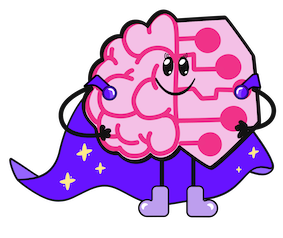

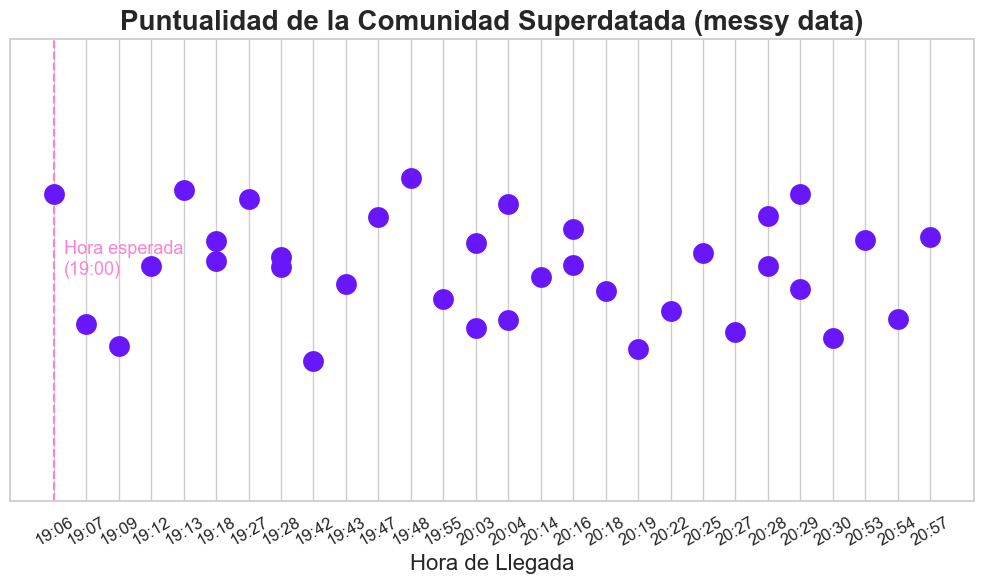

In [28]:
# Estilo visual y limpieza de datos
sns.set_theme(style="whitegrid")

# Limpieza: elimina valores infinitos y nulos en DiffMinutos
df_fotos = df_fotos.replace([float('inf'), float('-inf')], pd.NA)
df_fotos = df_fotos.dropna(subset=["DiffMinutos"])

# Suprime warnings de pandas sobre use_inf_as_na
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # Figura y gráfico
    plt.figure(figsize=(10, 6))
    sns.stripplot(
        data=df_fotos,
        x="HoraLlegada",
        size=15,
        color="#6816fa",
        jitter=0.2
    )

    # Línea de referencia en la hora esperada
    plt.axvline(0, color='#ff81d2', linestyle='--', linewidth=1.5)
    plt.text(
        0.3, 0.02,
        'Hora esperada\n(19:00)',
        color='#ff81d2',
        fontsize=13,
        va='bottom'
    )

    plt.title("Puntualidad de la Comunidad Superdatada (messy data)", fontsize=20, weight='bold')
    plt.xlabel("Hora de Llegada", fontsize=16)
    plt.yticks([])
    plt.xticks(fontsize=12,rotation=30)
    plt.tight_layout()
    plt.savefig("puntualidad_general.png", dpi=300)
    plt.show()

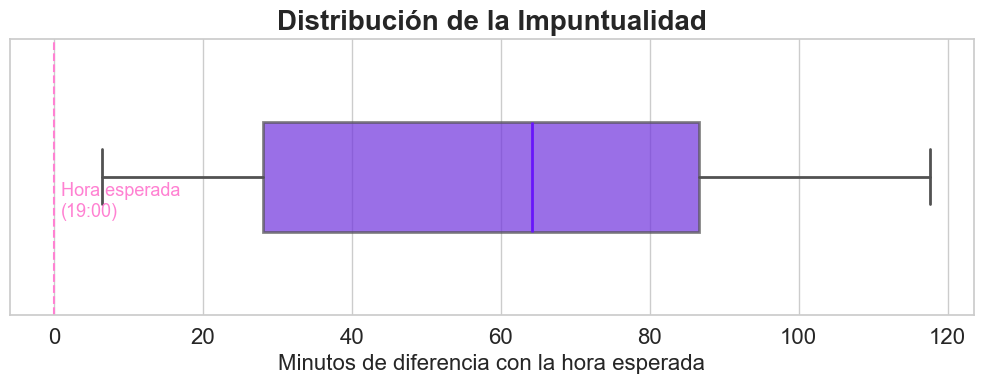

In [8]:
# Crear figura y boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(
    x=df_fotos['DiffMinutos'],
    width=0.4,
    color="#6816fa",
    boxprops=dict(alpha=0.7, linewidth=2),
    medianprops=dict(color="#6816fa", linewidth=2),
    whiskerprops=dict(linewidth=2),
    capprops=dict(linewidth=2),
    flierprops=dict(marker="o", markersize=6, markerfacecolor="crimson", alpha=0.5)
)

# Línea vertical en la hora esperada
plt.axvline(0, color='#ff81d2', linestyle='--', linewidth=1.5)

# Texto junto a la línea vertical
plt.text(
    1, 0.02,  # Ajusta si tus valores están lejos del 0
    'Hora esperada\n(19:00)',
    color='#ff81d2',
    fontsize=13,
    va='top'
)

# Título y etiquetas
plt.title("Distribución de la Impuntualidad", fontsize=20, weight='bold')
plt.xlabel("Minutos de diferencia con la hora esperada", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks([])  # Quitamos eje Y para limpieza visual

plt.tight_layout()

# Mostrar el gráfico
plt.show()